In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
% matplotlib inline

In [35]:
train = pd.read_csv('train.csv')
train = train.rename(index=str, columns={'i':'cust', 'j': 'cat', 't':'week'})

In [36]:
custs = np.sort(train['cust'].unique())
custs.shape
cats = np.sort(train['cat'].unique())
cats.shape
weeks = np.sort(train['week'].unique())
weeks.shape

(49,)

In [37]:
train_full = pd.DataFrame(data=list(product(custs, cats, weeks)), columns=['cust', 'cat', 'week'])
train_full = train_full.sort_values(by=['week', 'cust', 'cat'])
train_full['cat'] = train_full['cat'].astype('uint8')
train_full['week'] = train_full['week'].astype('uint8')
train_full['cust'] = train_full['cust'].astype('uint16')

In [38]:
categories = train.drop_duplicates(subset=['cat', 'week']).drop(['cust'], axis=1)
categories.head()

,cat,week,price,advertised
0,7,0,2.137451,0
1,1,0,0.863341,0
2,6,0,0.799155,0
3,25,0,3.023893,0
5,30,0,1.961365,0


In [39]:
train_full = train_full.merge(categories , how='left', on=('cat', 'week'), copy=False)

In [40]:
train['purch'] = 1
train.head()

,cust,cat,week,price,advertised,purch
0,4,7,0,2.137451,0,1
1,6,1,0,0.863341,0,1
2,8,6,0,0.799155,0,1
3,8,25,0,3.023893,0,1
4,9,6,0,0.799155,0,1


In [41]:
key = ['cust', 'cat', 'week']
train_full = train_full.merge(train[key + ['purch']], how='left', on=key)

In [45]:
train_full.fillna(0, inplace=True)
train_full['purch'] = train_full['purch'].astype('uint')
train_full.head()

,cust,cat,week,price,advertised,purch
0,0,0,0,1.717944,0.0,0
1,0,1,0,0.863341,0.0,0
2,0,2,0,3.366060,0.0,0
3,0,3,0,0.699985,0.0,0
4,0,4,0,2.012190,0.0,0


In [46]:
train_full.describe()

,cust,cat,week,price,advertised,purch
count,3.920000e+06,3.920000e+06,3.920000e+06,3.920000e+06,3.920000e+06,3.920000e+06
mean,9.995000e+02,1.950000e+01,2.400000e+01,1.837502e+00,4.081633e-02,1.951582e-02
std,5.773503e+02,1.154340e+01,1.414214e+01,7.908284e-01,1.978645e-01,1.383292e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.997500e+02,9.750000e+00,1.200000e+01,1.153544e+00,0.000000e+00,0.000000e+00
50%,9.995000e+02,1.950000e+01,2.400000e+01,1.795105e+00,0.000000e+00,0.000000e+00
75%,1.499250e+03,2.925000e+01,3.600000e+01,2.302829e+00,0.000000e+00,0.000000e+00
max,1.999000e+03,3.900000e+01,4.800000e+01,3.366060e+00,1.000000e+00,1.000000e+00


In [18]:
# median = train[['cat', 'price']].groupby('cat').median()
# train['price_median'] = train['cat'].map(median['price'])
# train['discount'] = (train['price'] < train['price_median']).astype(int)
# train.drop(['price_median'], axis=1, inplace=True)
# train.head(5)

,cust,cat,week,price,advertised,discount
0,0,0,0,1.717944,0.0,0
1,0,1,0,0.863341,0.0,0
2,0,2,0,3.366060,0.0,0
3,0,3,0,0.699985,0.0,0
4,0,4,0,2.012190,0.0,0


In [61]:
dtrain = train_full[train_full['week']<45]
dtest = train_full[train_full['week']>=45]

In [62]:
X_train = dtrain.drop('purch', axis=1)
y_train = dtrain['purch']
X_test = dtest.drop('purch', axis=1)
y_test = dtest['purch']

In [128]:
lgb = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.02,
        num_leaves=30,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        scale_pos_weight=3)

In [ ]:
lgb.fit(X_train, y_train, verbose=10, eval_metric='auc',
       eval_set= [(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.785102	valid_1's auc: 0.781379


In [115]:
y_pred = lgb.predict_proba(X_test)

In [116]:
auc = roc_auc_score(y_test, y_pred[:, 1])
auc

0.7892318492486309

In [117]:
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

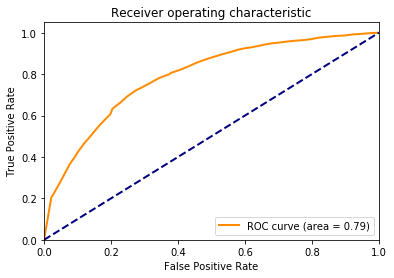

In [118]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [121]:
accuracy_score(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets